# Titanic Survival Project

### Overview

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

## Importing Libraries and Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
training = pd.read_csv('train.csv')
testing  = pd.read_csv('test.csv')

In [5]:
testing.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
training.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Exploration

In [8]:
# initial look at our data types and null counts
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
# Splitting the training data into numerical and categorical 
df_num = training[['Age', 'SibSp', 'Parch', 'Fare']]
df_cat = training[['Survived','Pclass', 'Sex', 'Cabin', 'Embarked']]

In [10]:
# a look at the numerical measures of centrality
df_num.describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


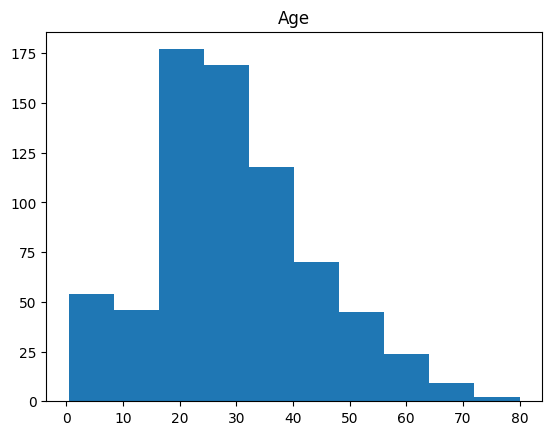

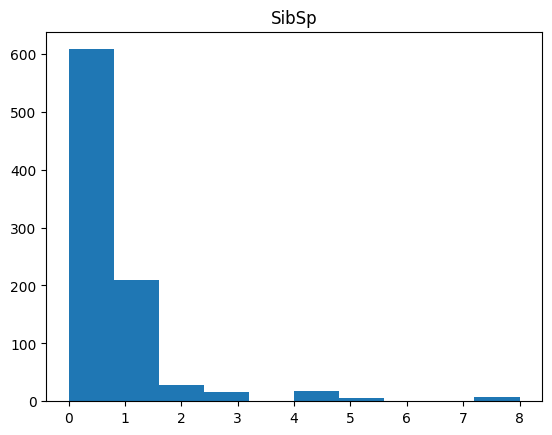

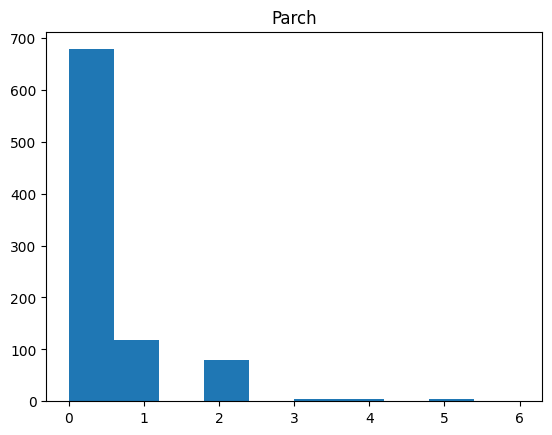

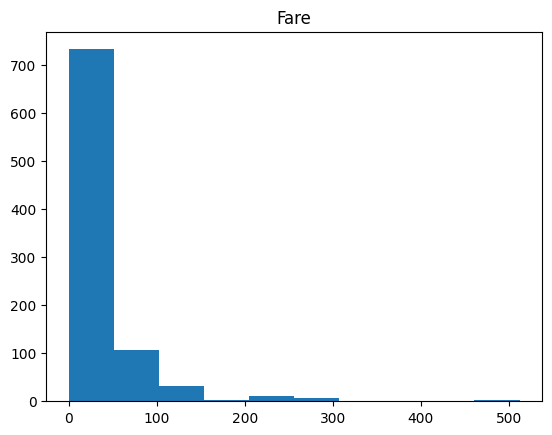

In [12]:
# looking at distributions of the numerical data
for n in df_num.columns:
    plt.hist(df_num[n])
    plt.title(n)
    plt.show()

* Age has normal distribution while the others do not.
* we might have to normalize Fare using log for better model results

<Axes: >

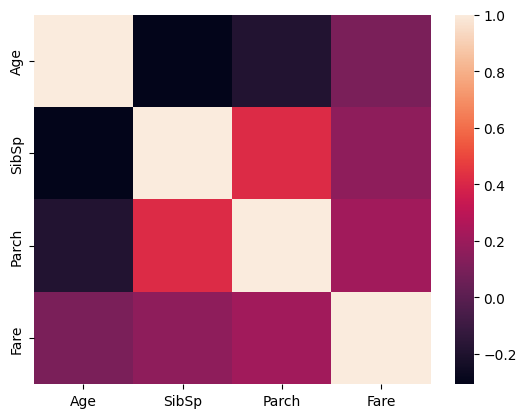

In [13]:
# taking a look at the correlation of the data
sns.heatmap(df_num.corr())

In [14]:
# survival rate based on average age, sibsp, parch and fare
pd.pivot_table(training, index='Survived', values=['Age', 'SibSp', 'Parch', 'Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


* Basic Look shows that younger people on average had a better chance of surviving
* The more someone paid as fare the higher the chance of survival. Which we can infere that first class passengers had preference to get on life rafts
* there was a women and children first approach which could explain why having a parent or child aboard increased chances of survivng

In [17]:
df_cat['Pclass'].value_counts().index

Index([3, 1, 2], dtype='int64', name='Pclass')

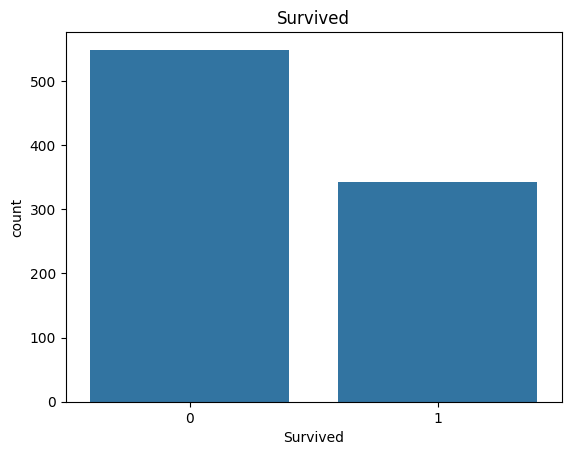

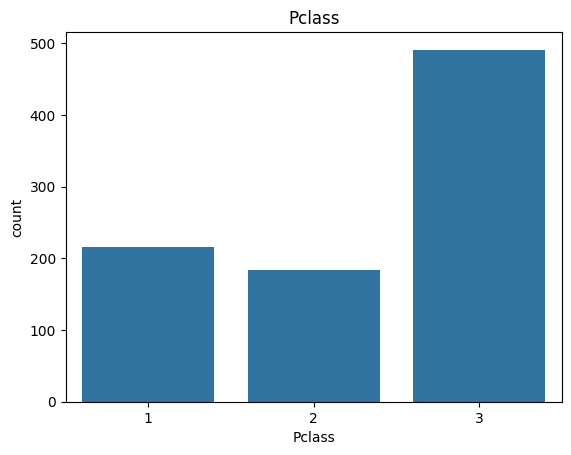

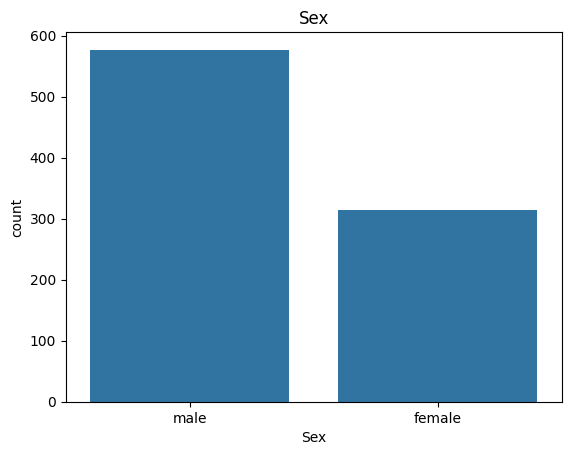

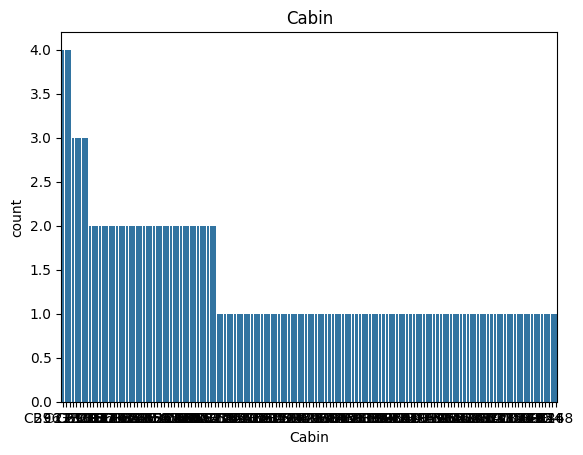

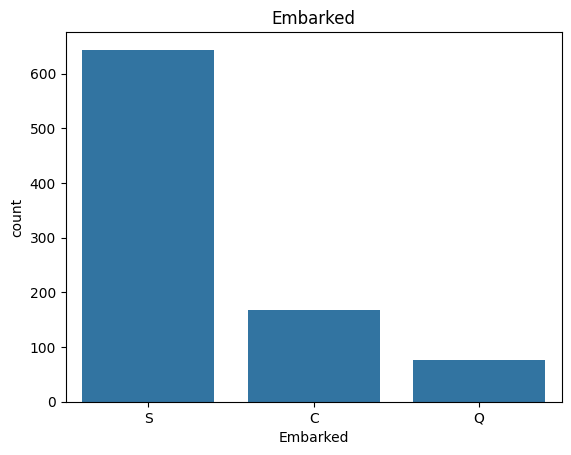

In [18]:
# checking categorical data value counts
for c in df_cat.columns:
    sns.barplot(x=df_cat[c].value_counts().index, y=df_cat[c].value_counts())
    plt.title(c)
    plt.show()

In [21]:
# too many categories for cabin, so we split it by deck letter. With n standing for null (people without cabins i.e. most 3rd class passengers)
training['cabin_adv'] = training.Cabin.apply(lambda x: str(x)[0])
training['cabin_adv'].value_counts()

cabin_adv
n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64

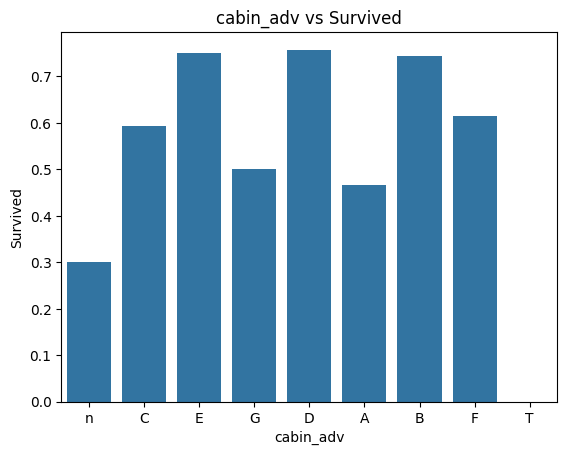

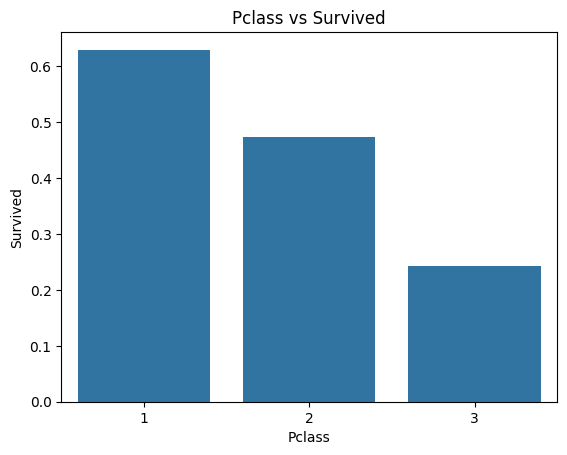

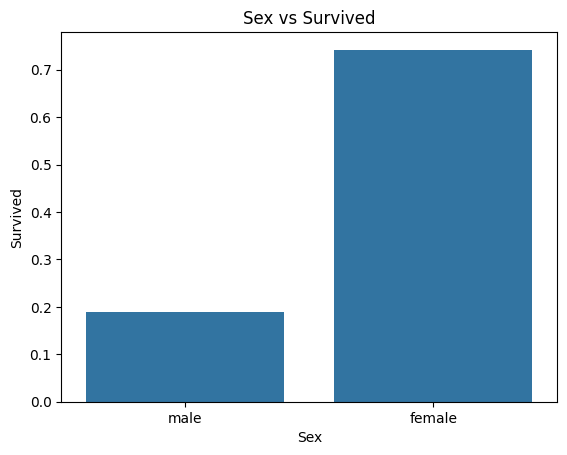

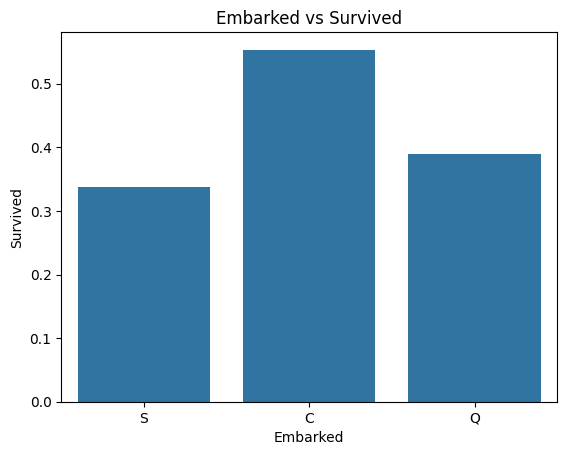

In [28]:
# checking effect of categories on survival rate
cat_names = ['cabin_adv', 'Pclass', 'Sex', 'Embarked']

for i in cat_names:
    sns.barplot(data = training, x=i, y='Survived', errorbar=None)
    plt.title(f'{i} vs Survived')
    plt.show()


* We have visualised how the categories affect the surivival rate of passengers

In [29]:
# making sure our testing data has the same columns from the feature engineering
testing['cabin_adv'] = training.Cabin.apply(lambda x: str(x)[0])
testing['cabin_adv'].value_counts()

cabin_adv
n    326
C     32
B     16
D     14
E     11
F      8
A      6
G      4
T      1
Name: count, dtype: int64

# Data Preprocessing

Steps:
* Select relevant data for modelling
* Deal with missing data
* Encode categorical data
* Scaling
* normalizing data (fare column)

In [30]:
# Missing data counts
training.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
cabin_adv        0
dtype: int64

* 